<h1>Training a fully-connected neural model</h1>

adapted from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [64]:
import sys
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline


In [65]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [36]:
trainset
testset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

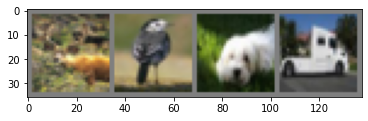

 deer  bird   dog truck


In [66]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [12]:
images[0].size()

torch.Size([3, 32, 32])

In [13]:
torch.flatten(images[0]).size()

torch.Size([3072])

In [97]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, hidden_dim=400, num_hidden=1):
        super(Net, self).__init__()
        self.hidden_dim=hidden_dim
        self.num_hidden=num_hidden
        self.layer_list = nn.ModuleList([])
        
        prev_dim = 3*32*32
        for layer_id in range(num_hidden):
            fc = nn.Linear(prev_dim, hidden_dim)
            prev_dim = hidden_dim
            self.layer_list.append(fc)
        self.fc2 = nn.Linear(prev_dim, 10)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        h = x
        for layer_id in range(self.num_hidden):
            z = self.layer_list[layer_id](h)
            h = F.relu(z)
        z = self.fc2(h)
        return z


net = Net(num_hidden=2)

In [102]:
net.fc2.weight

Parameter containing:
tensor([[-0.0372,  0.0483, -0.0267,  ..., -0.0477, -0.0045,  0.0334],
        [-0.0435, -0.0195,  0.0079,  ..., -0.0368, -0.0312,  0.0325],
        [-0.0421, -0.0087, -0.0081,  ...,  0.0297,  0.0329,  0.0369],
        ...,
        [-0.0200, -0.0272, -0.0193,  ..., -0.0164, -0.0058, -0.0185],
        [-0.0081,  0.0192, -0.0213,  ...,  0.0404,  0.0436, -0.0135],
        [ 0.0161, -0.0056,  0.0239,  ...,  0.0113,  0.0296, -0.0457]],
       device='cuda:0', requires_grad=True)

In [101]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
print(device)

net = net.to(device)

cuda:0


In [92]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [93]:
num_epochs = 4

for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.909
[1,  4000] loss: 1.714
[1,  6000] loss: 1.647
[1,  8000] loss: 1.606
[1, 10000] loss: 1.536
[1, 12000] loss: 1.524
[2,  2000] loss: 1.421
[2,  4000] loss: 1.437
[2,  6000] loss: 1.425
[2,  8000] loss: 1.427
[2, 10000] loss: 1.399
[2, 12000] loss: 1.404
[3,  2000] loss: 1.285
[3,  4000] loss: 1.286
[3,  6000] loss: 1.325
[3,  8000] loss: 1.303
[3, 10000] loss: 1.305
[3, 12000] loss: 1.315
[4,  2000] loss: 1.198
[4,  4000] loss: 1.188
[4,  6000] loss: 1.218
[4,  8000] loss: 1.216
[4, 10000] loss: 1.217
[4, 12000] loss: 1.222
Finished Training


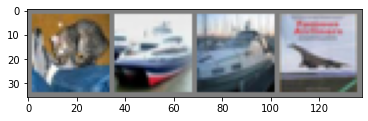

GroundTruth:    cat  ship  ship plane


In [94]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images, labels = torch.Tensor(images).to(device), labels

# print images
imshow(torchvision.utils.make_grid(images.cpu()))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [95]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat truck  ship  ship


In [96]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 51 %
